# 🔥 Ejemplo de Entrenamiento ViT con timm
Usando `timm` para entrenar un Vision Transformer sobre imágenes clasificadas del dataset FLAME.

In [10]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
print("Usando dispositivo:", device)


Usando dispositivo: cuda


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 50
best_acc = 0.0  # Para guardar el mejor modelo


In [14]:
# Transforms y Loaders
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_ds = datasets.ImageFolder("../data/Training", transform=transform)
val_ds = datasets.ImageFolder("../data/Test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

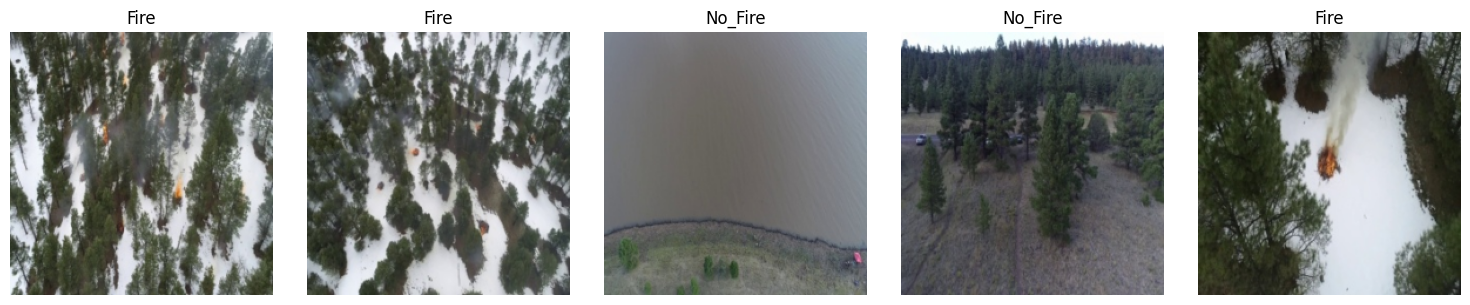

In [15]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torchvision.transforms.functional import to_pil_image
import random

# Transformación igual a la del entrenamiento (sin normalizar para visualización)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Ruta al dataset de entrenamiento
train_ds = datasets.ImageFolder("../data/Training", transform=transform)

# Seleccionar 5 imágenes aleatorias
indices = random.sample(range(len(train_ds)), 5)
samples = [train_ds[i] for i in indices]

# Mostrar las imágenes y sus clases
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, (img_tensor, label) in enumerate(samples):
    axs[i].imshow(to_pil_image(img_tensor))
    axs[i].set_title(train_ds.classes[label])
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [16]:
# modelo ViT desde timm
model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=2)
model.to(device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

# Calcular pesos inversamente proporcionales a la frecuencia
fire_count = 25018
no_fire_count = 14357
total = fire_count + no_fire_count

# Ponderación: menos imágenes → mayor peso
weight_fire = total / (2 * fire_count)
weight_no_fire = total / (2 * no_fire_count)

weights = torch.tensor([weight_fire, weight_no_fire]).to(device)

# ✅ Función de pérdida ponderada
criterion = nn.CrossEntropyLoss(weight=weights)

# Optimizador
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Entrenamiento
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    # Evaluación en validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    val_acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Guardar mejor modelo
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_vit_model2_50_video.pth")
        print("Nuevo mejor modelo guardado.")


Epoch 1/50 | Loss: 0.0296 | Val Acc: 0.6766
Nuevo mejor modelo guardado.
Epoch 2/50 | Loss: 0.0178 | Val Acc: 0.6671
Epoch 3/50 | Loss: 0.0147 | Val Acc: 0.6440
Epoch 4/50 | Loss: 0.0129 | Val Acc: 0.7072
Nuevo mejor modelo guardado.
Epoch 5/50 | Loss: 0.0122 | Val Acc: 0.6926
Epoch 6/50 | Loss: 0.0105 | Val Acc: 0.6498
Epoch 7/50 | Loss: 0.0102 | Val Acc: 0.7489
Nuevo mejor modelo guardado.
Epoch 8/50 | Loss: 0.0109 | Val Acc: 0.6334
Epoch 9/50 | Loss: 0.0094 | Val Acc: 0.7593
Nuevo mejor modelo guardado.
Epoch 10/50 | Loss: 0.0064 | Val Acc: 0.6307
Epoch 11/50 | Loss: 0.0077 | Val Acc: 0.7030
Epoch 12/50 | Loss: 0.0085 | Val Acc: 0.6920
Epoch 13/50 | Loss: 0.0076 | Val Acc: 0.6466
Epoch 14/50 | Loss: 0.0074 | Val Acc: 0.7318
Epoch 15/50 | Loss: 0.0076 | Val Acc: 0.7201
Epoch 16/50 | Loss: 0.0055 | Val Acc: 0.6448
Epoch 17/50 | Loss: 0.0069 | Val Acc: 0.6513
Epoch 18/50 | Loss: 0.0057 | Val Acc: 0.6939
Epoch 19/50 | Loss: 0.0058 | Val Acc: 0.6814
Epoch 20/50 | Loss: 0.0075 | Val Acc: 

In [19]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        preds = model(x).argmax(dim=1).cpu()
        all_preds.extend(preds.tolist())
        all_labels.extend(y.tolist())

print(classification_report(all_labels, all_preds, target_names=train_ds.classes))

              precision    recall  f1-score   support

        Fire       0.71      0.80      0.75      5137
     No_Fire       0.63      0.52      0.57      3480

    accuracy                           0.69      8617
   macro avg       0.67      0.66      0.66      8617
weighted avg       0.68      0.69      0.68      8617



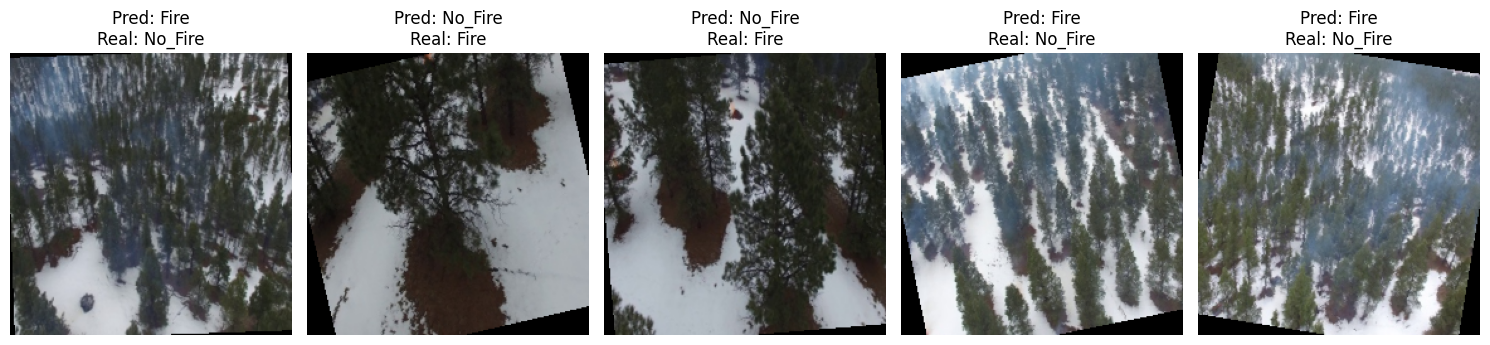

In [22]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random

# Función para desnormalizar (invierte Normalize([0.5]*3, [0.5]*3))
def denormalize(tensor):
    return tensor * 0.5 + 0.5

# Guardar imágenes mal clasificadas
wrong_samples = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1)

        for img_tensor, pred, true in zip(x, preds, y):
            if pred != true:
                wrong_samples.append((img_tensor.cpu(), pred.item(), true.item()))

# Seleccionar y mostrar 5 errores aleatorios (o menos si hay pocos)
n = min(5, len(wrong_samples))
samples_to_show = random.sample(wrong_samples, n)

# Mostrar visualmente
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, true) in enumerate(samples_to_show):
    img = denormalize(img_tensor)  # ✅ desnormalizar
    axs[i].imshow(to_pil_image(img))
    axs[i].set_title(f"Pred: {train_ds.classes[pred]}\nReal: {train_ds.classes[true]}")
    axs[i].axis("off")

plt.tight_layout()
plt.show()

In [33]:
print(train_ds.classes)  # ['Fire', 'No_Fire']


['Fire', 'No_Fire']


In [76]:
from PIL import Image

# Ruta de la imagen que quieres predecir
# image_path = "../data/Test/No_Fire/resized_test_nofire_frame21.jpg"
image_path = "../data/Test/Fire/resized_test_fire_frame5017.jpg"
# image_path = "../data/mydata/real.jpg"

# Preprocesamiento (debe ser igual al del entrenamiento)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Abrir imagen y preparar
img = Image.open(image_path).convert("RGB")
input_tensor = transform(img).unsqueeze(0).to(device)

# Inferen
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    pred_class = output.argmax(dim=1).item()

#resultado
class_names = train_ds.classes
print(f"La imagen fue clasificada como: {class_names[pred_class]}")

La imagen fue clasificada como: Fire


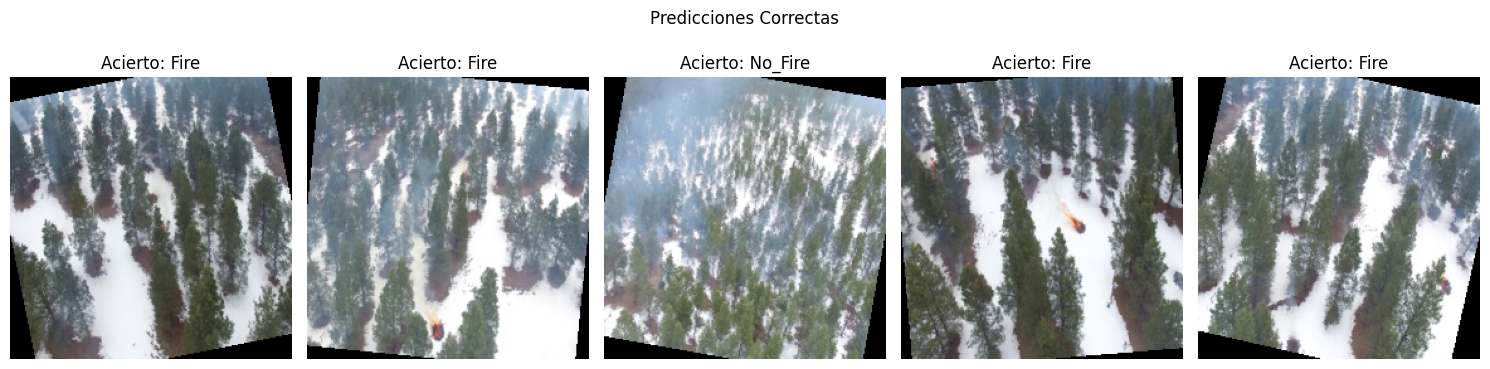

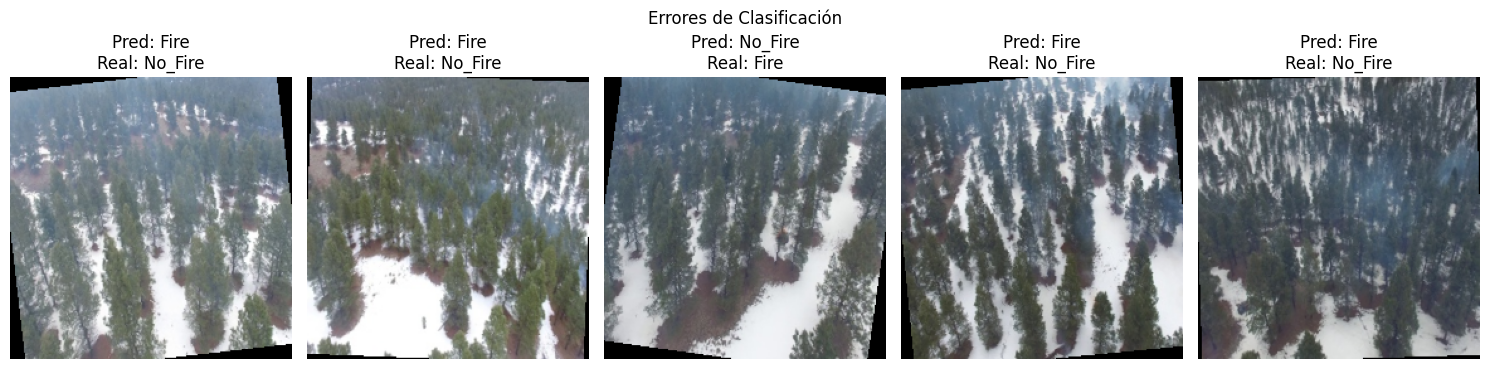

In [23]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random
import torch

# Función para desnormalizar
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5  # invierte Normalize([0.5]*3, [0.5]*3)

correct_samples = []
wrong_samples = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1)

        for img_tensor, pred, true in zip(x, preds, y):
            if pred == true:
                correct_samples.append((img_tensor.cpu(), pred.item(), true.item()))
            else:
                wrong_samples.append((img_tensor.cpu(), pred.item(), true.item()))

# Cantidad de muestras a mostrar
n = min(5, len(correct_samples), len(wrong_samples))
correct_show = random.sample(correct_samples, n)
wrong_show = random.sample(wrong_samples, n)

# Mostrar aciertos
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, _) in enumerate(correct_show):
    axs[i].imshow(to_pil_image(denormalize(img_tensor)))
    axs[i].set_title(f"Acierto: {train_ds.classes[pred]}")
    axs[i].axis("off")
plt.suptitle("Predicciones Correctas")
plt.tight_layout()
plt.show()

# Mostrar errores
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, true) in enumerate(wrong_show):
    axs[i].imshow(to_pil_image(denormalize(img_tensor)))
    axs[i].set_title(f"Pred: {train_ds.classes[pred]}\nReal: {train_ds.classes[true]}")
    axs[i].axis("off")
plt.suptitle("Errores de Clasificación")
plt.tight_layout()
plt.show()

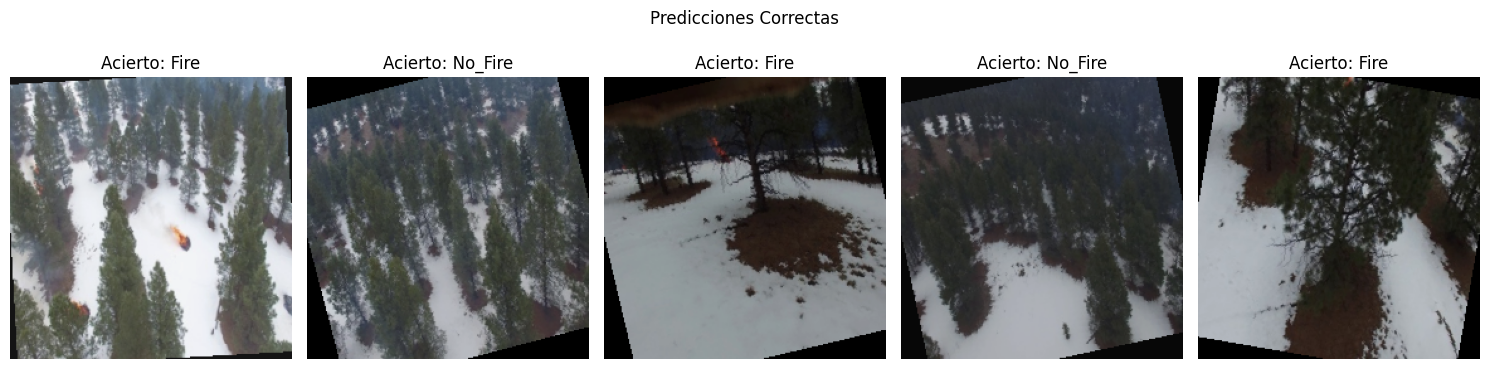

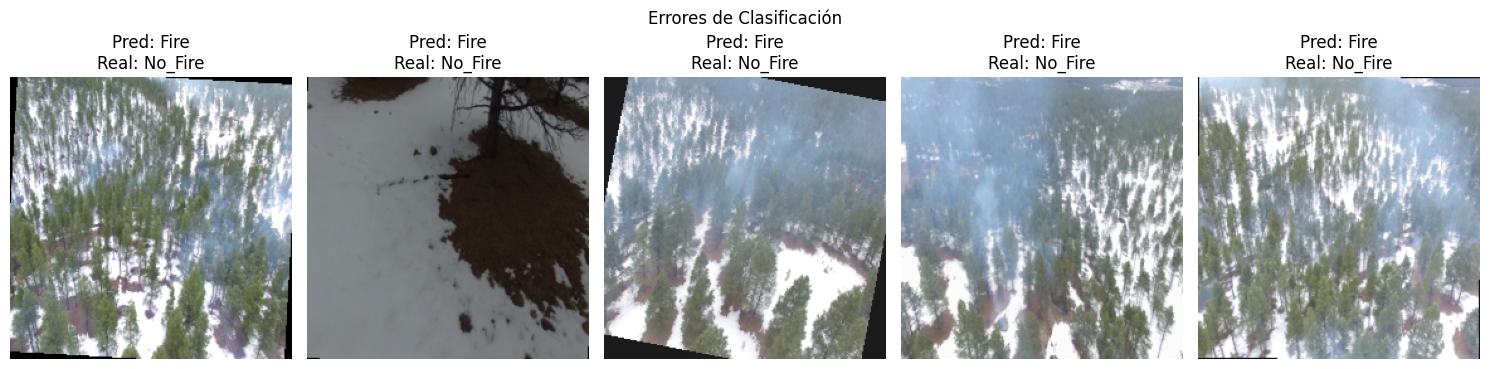

In [ ]:
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random
import torch

# Función para desnormalizar
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5  # invierte Normalize([0.5]*3, [0.5]*3)

correct_samples = []
wrong_samples = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1)

        for img_tensor, pred, true in zip(x, preds, y):
            if pred == true:
                correct_samples.append((img_tensor.cpu(), pred.item(), true.item()))
            else:
                wrong_samples.append((img_tensor.cpu(), pred.item(), true.item()))

# Cantidad de muestras a mostrar
n = min(5, len(correct_samples), len(wrong_samples))
correct_show = random.sample(correct_samples, n)
wrong_show = random.sample(wrong_samples, n)

# Mostrar aciertos
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, _) in enumerate(correct_show):
    axs[i].imshow(to_pil_image(denormalize(img_tensor)))
    axs[i].set_title(f"Acierto: {train_ds.classes[pred]}")
    axs[i].axis("off")
plt.suptitle("Predicciones Correctas")
plt.tight_layout()
plt.show()

# Mostrar errores
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, true) in enumerate(wrong_show):
    axs[i].imshow(to_pil_image(denormalize(img_tensor)))
    axs[i].set_title(f"Pred: {train_ds.classes[pred]}\nReal: {train_ds.classes[true]}")
    axs[i].axis("off")
plt.suptitle("Errores de Clasificación")
plt.tight_layout()
plt.show()


In [14]:
# Guardar modelo al final del entrenamiento
torch.save(model.state_dict(), "modelo_entrenado_vit.pth")
print("Modelo guardado en: modelo_entrenado_vit.pth")

Modelo guardado en: modelo_entrenado_vit.pth


In [ ]:
model = MiModeloViT()  # instancia igual al original
model.load_state_dict(torch.load("modelo_entrenado_vit.pth"))
model.to(device)
model.eval()

In [1]:
import torch
print(torch.__version__)
print("CUDA disponible:", torch.cuda.is_available())

2.7.1+cpu
CUDA disponible: False


In [2]:
import torch
print(torch.__version__)  # Debería decir algo como 2.1.0+cu118
print(torch.cuda.is_available())  # Esto debe dar: True
print(torch.cuda.get_device_name(0))  # Te dirá el nombre de tu GPU

2.1.0+cu121
True
NVIDIA GeForce RTX 3070


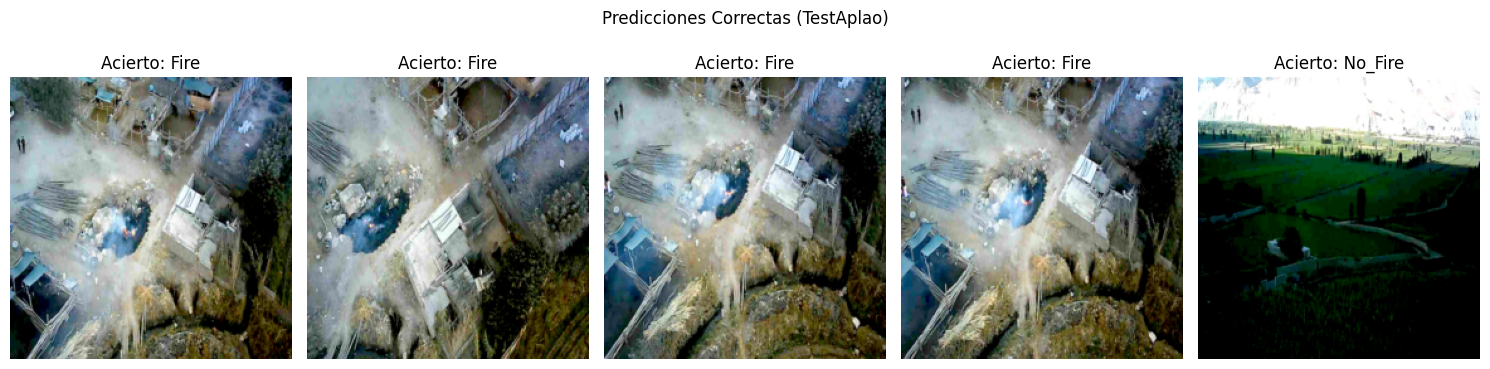

TypeError: 'Axes' object is not subscriptable

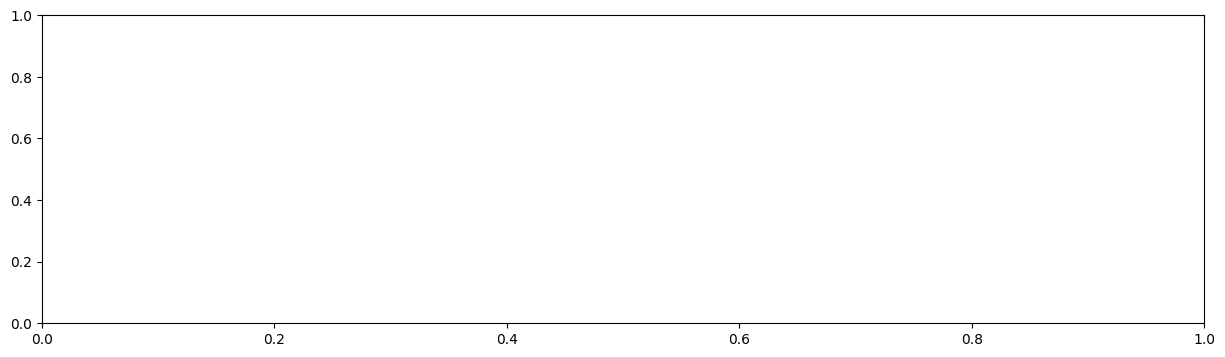

In [24]:
import torch
import timm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
import random

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. Cargar modelo Swin-Tiny entrenado ---
model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load("best_vit_model2_50_video.pth", map_location=device))
model.to(device)
model.eval()

# --- 2. Definir transformaciones y DataLoader externo ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Ruta con subcarpetas Fire/ y No_Fire/
external_dataset = datasets.ImageFolder("../data/mydata/aplao", transform=transform)
external_loader = DataLoader(external_dataset, batch_size=16, shuffle=False)

# --- 3. Evaluar y visualizar ---
def denormalize(img_tensor):
    return img_tensor * 0.5 + 0.5

correct_samples = []
wrong_samples = []

with torch.no_grad():
    for x, y in external_loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        preds = outputs.argmax(dim=1)

        for img_tensor, pred, true in zip(x, preds, y):
            if pred == true:
                correct_samples.append((img_tensor.cpu(), pred.item(), true.item()))
            else:
                wrong_samples.append((img_tensor.cpu(), pred.item(), true.item()))

# Mostrar 5 ejemplos de aciertos
n = min(5, len(correct_samples))
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, _) in enumerate(random.sample(correct_samples, n)):
    axs[i].imshow(to_pil_image(denormalize(img_tensor)))
    axs[i].set_title(f"Acierto: {external_dataset.classes[pred]}")
    axs[i].axis("off")
plt.suptitle("Predicciones Correctas (TestAplao)")
plt.tight_layout()
plt.show()

# Mostrar 5 ejemplos de errores
n = min(5, len(wrong_samples))
fig, axs = plt.subplots(1, n, figsize=(15, 4))
for i, (img_tensor, pred, true) in enumerate(random.sample(wrong_samples, n)):
    axs[i].imshow(to_pil_image(denormalize(img_tensor)))
    axs[i].set_title(f"Pred: {external_dataset.classes[pred]}\nReal: {external_dataset.classes[true]}")
    axs[i].axis("off")
plt.suptitle("Errores de Clasificación (TestAplao)")
plt.tight_layout()
plt.show()


In [25]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import timm

# Cargar modelo
model = timm.create_model('vit_tiny_patch16_224', pretrained=False, num_classes=2)
model.load_state_dict(torch.load("best_vit_model2_50_video.pth"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Preprocesamiento
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
# Leer video
cap = cv2.VideoCapture("../data/mydata/aplao/WhatsApp Video 2025-07-08 at 8.32.43 PM.mp4")
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Crear nuevo video
out = cv2.VideoWriter("../data/mydata/videosprocesados/WhatsApp Video 2025-07-08 at 8.32.43 PM SALIDA VIT 2.mp4", cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Clasificar frame
    img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    input_tensor = transform(img).unsqueeze(0).to("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()

    # Mostrar resultado en frame
    label = "FIRE" if pred == 0 else "NO FIRE"
    color = (0, 0, 255) if label == "FIRE" else (0, 255, 0)

    cv2.putText(frame, f"Pred: {label}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, color, 3)

    # Escribir frame en nuevo video
    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()